## Diversity analysis for the TSCA Active constrained inventory

Last modified: 06 February 2024<br>
Explore the question of what diverse substances would practically be selected for each terminal category to meet the 80% threshold and do any of them have data in ToxVal already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

#### Updating since TSCA status has changed

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_categorisations_wCDR_061123.xlsx')

In [6]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,tsca_dist,MaxMin_tsca_picks,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS
0,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,0.375,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,0.625,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,0.600,0.0,NaN,NaN,DTXSID6027426,DTXSID1071907,0.6,0.0,NaN,NaN
3,DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Constraining the universe to TSCA and computing centroids and MaxMin from the contrained inventory

Calculate centroids for terminal categories but constraining the substances to those with substances on the TSCA ACTIVE inventory

In [7]:
pfas_tsca = df[df['TSCA_STATUS']== 'active']

In [8]:
pfas_tsca.shape

(321, 89)

In [9]:
results_subcats = {}
for i, group in pfas_tsca.groupby('group_str'):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_subcats[i] = a


In [10]:
distances_subcats = {}
for k,v in results_subcats.items():
    a = distance_matrix(results_subcats[k])
    distances_subcats[k] = a

In [11]:
len(results_subcats)


57

In [12]:
len({k:v.shape[0] for k,v in results_subcats.items() if v.shape[0] >5})

16

In [13]:
len(distances_subcats)

57

In [14]:
centres = []
for i,group in pfas_tsca.groupby('group_str'):
    try:
        m = medoid_calc(distances_subcats[i])
        centres.append(m)
    except Exception as error:
        print(error)


In [15]:
pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)

/tmp/ipykernel_1283700/1021335603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)


In [16]:
pfas_tsca.tsca_centroid.value_counts()

centroid    57
Name: tsca_centroid, dtype: int64

In [17]:
df3 = pfas_tsca.copy()

In [18]:
df_3 = df3.set_index('dtxsid')

In [19]:
members = {}

for i, group in df_3.groupby('group_str'):
    subset = group[['group_str', 'tsca_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_subcats[i][x].index, distances_subcats[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)

In [20]:
cluster_members = pd.DataFrame(list(members.items()))
cluster_members.columns = ['tsca_centroid', 1]
cluster_members[['lvl2_analogues','lvl2_Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members_1 = cluster_members.apply(pd.Series.explode)
cluster_members_1.head()


,tsca_centroid,lvl2_analogues,lvl2_Dist
0,DTXSID6027426,DTXSID1071907,0.6
0,DTXSID6027426,DTXSID6071665,0.391304
0,DTXSID6027426,DTXSID1067629,0.625
0,DTXSID6027426,DTXSID1032646,0.6
0,DTXSID6027426,DTXSID7027831,0.391304


In [21]:
df3['tsca_centroid_id'] = df3.apply(lambda x: x['dtxsid'] if x['tsca_centroid'] == 'centroid' else np.nan, axis = 1)


In [22]:
df3 = df3.sort_values(by = ['group_str', 'tsca_centroid_id'], ascending = [True, False])

In [23]:
df3['tsca_centroid_id2'] = df3['tsca_centroid_id'].fillna(method = 'ffill')


In [24]:
mydict_ = {}
for i, group in df3.groupby('tsca_centroid_id2'):
    k = [n for n in group['tsca_centroid_id2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_[k] = v


In [25]:
len(list(mydict_.values()))

57

In [26]:
dist_ = []
for i, group in cluster_members_1.groupby('tsca_centroid'):
    a = cluster_members_1[(cluster_members_1['tsca_centroid'] == i) & (cluster_members_1['lvl2_analogues'].isin(mydict_[i]))]
    dist_.append(a)

In [27]:
dist_df = pd.concat([e for e in dist_])

In [28]:
df3_w = pd.merge(df3, dist_df[['lvl2_analogues', 'lvl2_Dist']], left_on = 'dtxsid', right_on = 'lvl2_analogues', how = 'left')


In [29]:
df3_w.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [30]:
df3_w.rename(columns = {'lvl2_analogues_x' : 'lvl2_analogues', 'lvl2_Dist_x' : 'lvl2_Dist', 'lvl2_analogues_y' : 'tsca_analogues' ,'lvl2_Dist_y' : 'tsca_dist'},  inplace = True)

In [31]:
df3_w.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS,tsca_analogues,tsca_dist
0,DTXSID6027426,DSSTox_High,N-Ethyl-N-(2-hydroxyethyl)perfluorooctane sulf...,1691-99-2,Single Compound,CCN(CCO)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C12H10F17NO3S/c1-2-30(3-4-31)34(32,33...",HUFHNYZNTFSKCT-UHFFFAOYSA-N,C12H10F17NO3S,571.25,...,centroid,DTXSID6027426,DTXSID6027426,DTXSID6027426,0.000000,1.0,NaN,NaN,DTXSID6027426,0.0
1,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,NaN,NaN,DTXSID6027426,DTXSID1071907,0.600000,0.0,NaN,NaN,DTXSID1071907,0.6
2,DTXSID6071665,DSSTox_High,Pentadecafluoro-N-(2-hydroxyethyl)-N-methyl-1-...,68555-76-0,Single Compound,CN(CCO)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,"InChI=1S/C10H8F15NO3S/c1-26(2-3-27)30(28,29)10...",UIZUTEDYGNRNSW-UHFFFAOYSA-N,C10H8F15NO3S,507.21,...,NaN,NaN,DTXSID6027426,DTXSID6071665,0.391304,0.0,NaN,NaN,DTXSID6071665,0.391304
3,DTXSID1067629,DSSTox_High,N-Methylperfluorooctanesulfonamide,31506-32-8,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C9H4F17NO2S/c1-27-30(28,29)9(25,26)7(...",SRMWNTGHXHOWBT-UHFFFAOYSA-N,C9H4F17NO2S,513.17,...,NaN,NaN,DTXSID6027426,DTXSID1067629,0.625000,1.0,NaN,NaN,DTXSID1067629,0.625
4,DTXSID1032646,DSSTox_High,N-Ethylperfluorooctane sulfonamide,4151-50-2,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C10H6F17NO2S/c1-2-28-31(29,30)10(26,2...",CCEKAJIANROZEO-UHFFFAOYSA-N,C10H6F17NO2S,527.20,...,NaN,NaN,DTXSID6027426,DTXSID1032646,0.600000,0.0,NaN,NaN,DTXSID1032646,0.6


Now have our centroids and pairwise distances for the tsca_pfas set

In [32]:
cats = df3_w['group_str'].unique().tolist()


In [33]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['dm'] = pd.DataFrame(squareform(pdist(pd.DataFrame(np.array(content['fp_dict']), index = content['t_dict'].keys()), 'jaccard')), index = content['t_dict'].keys(), columns = content['t_dict'].keys())
    content['k'] = k
    
    return content

In [34]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df3_w, k))
    except Exception as error:
        print(k)


In [35]:
from rdkit.SimDivFilters import MaxMinPicker

In [36]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict


In [37]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = lte_summaries[i]['nfp_dict']-1, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'],))



In [38]:
len(lte_summaries)

57

In [39]:
len([lte_summaries[i]['k'] for i in range(len(lte_summaries)) if lte_summaries[i]['nfp_dict'] <= 5])

41

In [40]:
index_pick = {k: picker_lst[k]['label'] for k in range(len(picker_lst))}
rev_index_picks = {v:k for k,v in index_pick.items()}

In [41]:
def representive(df, lst):
    temps = []
    for n in range(1,len(lst)):
        a = lst[:n]
        b = np.mean(np.min(df.loc[a], axis = 0))
        temps.append([n,b])
    new_df = pd.concat([pd.DataFrame(temps), np.cumsum(pd.DataFrame(temps)[1])], axis = 1)
    new_df.columns = ['#', 'min', 'cummin']
    new_df['norm_min'] = new_df['cummin']/np.sum(new_df['min'])
    return new_df

In [42]:
def summary_exp(i = 0):
    summary = {}
    k = lte_summaries[i]['k']
    x = rev_index_picks[k]
    summary['label'] = lte_summaries[i]['k']
    summary['representative'] = representive(lte_summaries[i]['dm'],picker_lst[x]['diverse_chems'])
    summary['chk'] = summary['label'], x
    return summary

In [43]:
len(picker_lst)

16

In [44]:
check_lst = []
for e in range(len(lte_summaries)):
    try:
        a = summary_exp(i=e)
    except Exception as error:
        print(e)
    finally:
        check_lst.append(a)


3
4
6
7
8
9
10
11
14
15
16
17
18
19
20
21
22
23
24
31
33
34
36
38
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [45]:
mydf = []
for i in range(0,len(check_lst)):
    a = check_lst[i]['representative']
    a['category'] = check_lst[i]['label']
    mydf.append(a)

In [46]:
newdf = pd.concat(mydf)

In [47]:
newdf['pct_norm_min'] = round(100*newdf['norm_min'],2)

In [48]:
new_df = pd.pivot_table(newdf, index = 'category', values = 'pct_norm_min', columns = '#')

In [49]:
new_df2 = new_df.copy()
new_df2 = new_df2.replace(np.nan,100)
new_df2

#,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
category,,,,,,,,,,,,,,,,,,,,,
"('FASA based PFAA precursors', 'gte7', nan, nan)",21.40,39.99,54.37,66.82,76.86,85.73,91.22,95.31,98.50,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('FASA based PFAA precursors', 'lt7', nan, nan)",28.99,53.82,70.00,83.33,89.56,93.55,96.16,97.94,99.03,99.70,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Fluorotelomer PFAA precursors', 'gte7', nan, nan)",34.88,66.66,85.35,96.46,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)",47.11,73.67,90.16,96.76,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",52.82,88.93,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Other aliphatics', 'gte7', 1.0, nan)",63.81,96.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Other aliphatics', 'lt7', 2.0, 4.0)",18.97,36.10,51.18,64.57,74.60,82.98,89.77,95.00,98.83,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Other aliphatics', 'lt7', 3.0, 1.0)",34.52,62.00,80.28,89.40,95.38,97.67,98.85,99.62,100.00,100.00,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0
"('Other aliphatics', 'lt7', 3.0, 2.0)",16.88,31.68,43.93,54.88,64.68,72.03,78.17,83.50,88.02,91.74,...,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.0


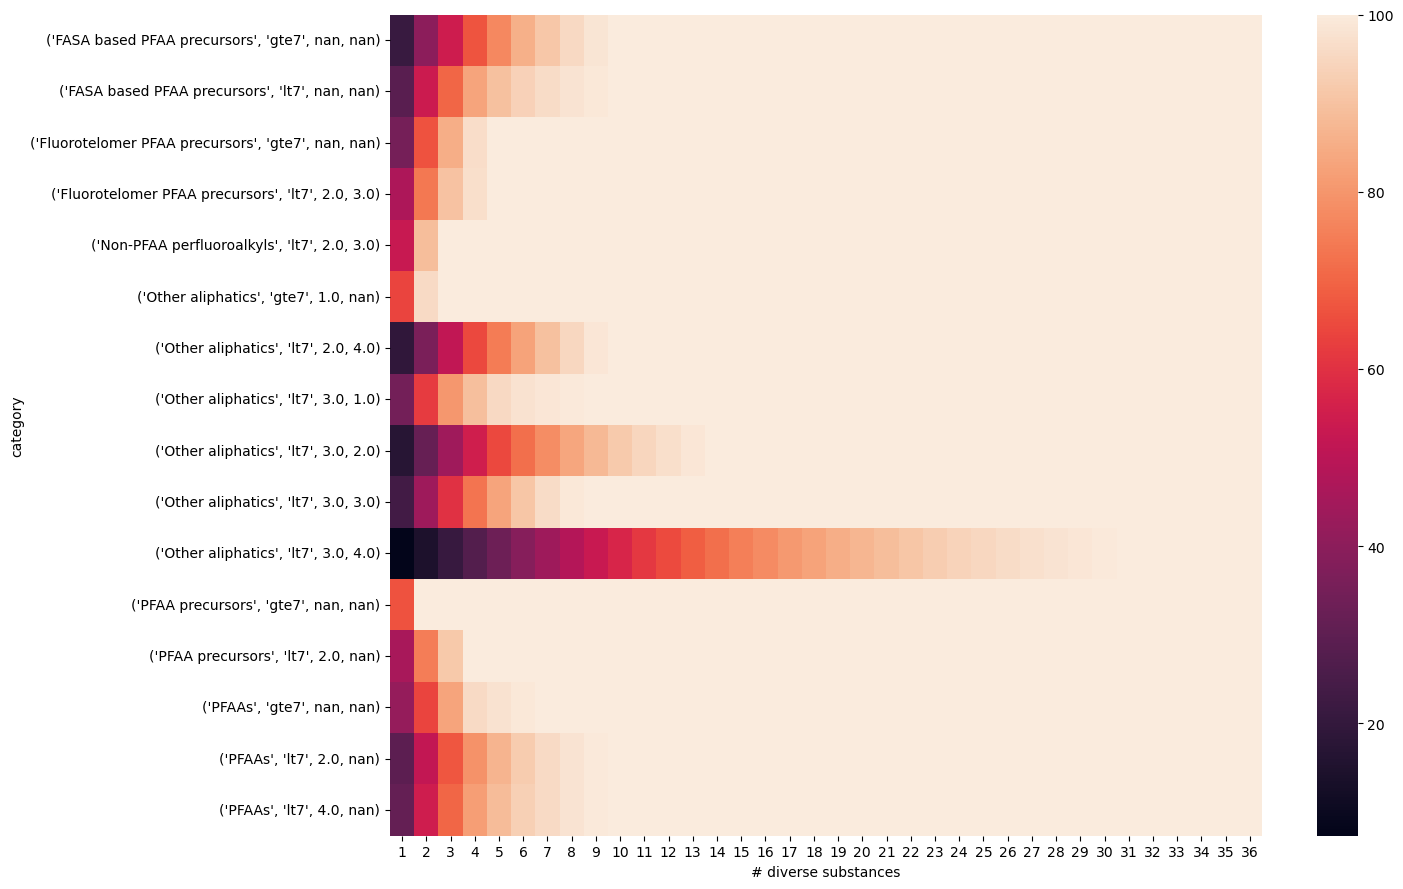

In [50]:
plt.figure(figsize = (15,9))
sns.heatmap(new_df2)
plt.xlabel('# diverse substances')
plt.tight_layout()
#plt.savefig(figures_dir+'structural_diversity_constrained.png', dpi = 300)

In [51]:
div = np.arange(5,100)

In [52]:
mycol = []
for i in div:
    for col in new_df2.columns:
        count = (new_df2[col] > i).sum()
        mycol.append([i, col, count])


In [53]:
dd = pd.DataFrame(mycol)

In [54]:
dd.columns = ['threshold', 'col', 'sum']

In [55]:
dd = pd.pivot_table(dd, index = 'col', columns = 'threshold', values = 'sum')

In [56]:
def how_many(df, threshold = 0.8):
    return df.loc[np.where(df['norm_min'] >threshold)[0][0], '#']

In [57]:
def threshold_3(df, threshold = 3):
    return df.loc[np.where(df['#'] == threshold)[0][0], 'norm_min']

In [58]:
number_chems = {}
for e in range(len(check_lst)):
    a = how_many(check_lst[e]['representative'], threshold = 0.8)
    b = check_lst[e]['label']
    c = np.round(threshold_3(check_lst[e]['representative'], threshold = 3)*100,2)
    d = check_lst[e]['representative'].shape[0]+1
    number_chems[b] =[a,c,d]

In [59]:
df2 = pd.concat([pd.DataFrame(list(number_chems.items())), pd.DataFrame(list(number_chems.items()))[1].apply(pd.Series)], axis=1)
df2.columns = ['terminal_category', 'temp', 'ideal#', '%diversity', 'category_size']
df2.drop(['temp'], axis = 1, inplace =True)

In [60]:
df2['ideal#'].sum()

76.0

In [61]:
74+53

127

In [62]:
df2[df2['%diversity'] >=50]

,terminal_category,ideal#,%diversity,category_size
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",6.0,54.37,17.0
1,"('FASA based PFAA precursors', 'lt7', nan, nan)",4.0,70.00,13.0
2,"('Fluorotelomer PFAA precursors', 'gte7', nan,...",3.0,85.35,24.0
3,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",3.0,90.16,9.0
4,"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",2.0,100.00,6.0
5,"('Other aliphatics', 'gte7', 1.0, nan)",2.0,100.00,6.0
6,"('Other aliphatics', 'lt7', 2.0, 4.0)",6.0,51.18,14.0
7,"('Other aliphatics', 'lt7', 3.0, 1.0)",3.0,80.28,11.0
9,"('Other aliphatics', 'lt7', 3.0, 3.0)",5.0,59.83,10.0
11,"('PFAA precursors', 'gte7', nan, nan)",2.0,100.00,11.0


In [64]:
df2

,terminal_category,ideal#,%diversity,category_size
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",6.0,54.37,17.0
1,"('FASA based PFAA precursors', 'lt7', nan, nan)",4.0,70.00,13.0
2,"('Fluorotelomer PFAA precursors', 'gte7', nan,...",3.0,85.35,24.0
3,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",3.0,90.16,9.0
4,"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",2.0,100.00,6.0
5,"('Other aliphatics', 'gte7', 1.0, nan)",2.0,100.00,6.0
6,"('Other aliphatics', 'lt7', 2.0, 4.0)",6.0,51.18,14.0
7,"('Other aliphatics', 'lt7', 3.0, 1.0)",3.0,80.28,11.0
8,"('Other aliphatics', 'lt7', 3.0, 2.0)",8.0,43.93,18.0
9,"('Other aliphatics', 'lt7', 3.0, 3.0)",5.0,59.83,10.0


In [65]:
df2.describe()

,ideal#,%diversity,category_size
count,16.000000,16.000000,16.000000
mean,4.750000,73.008125,14.250000
std,3.678768,22.709228,7.945649
min,2.000000,20.990000,6.000000
25%,3.000000,58.465000,9.750000
50%,3.500000,75.225000,12.000000
75%,5.250000,90.535000,17.250000
max,17.000000,100.000000,37.000000


In [64]:
df2.to_csv(interim_dir+'diversity_tsca_active_061123.csv')

In [66]:
number_chems2 = []


for e in range(len(check_lst)):
    for i in np.arange(0.1,1,0.1):
        a = how_many(check_lst[e]['representative'], threshold = i)
        #print(a)
        b = check_lst[e]['label']
        number_chems2.append([a,b,i])

In [67]:
df3 = pd.DataFrame(number_chems2, columns = ['#ideal', 'terminal_category', 'threshold'])
df3

,#ideal,terminal_category,threshold
0,1,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.1
1,1,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.2
2,2,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.3
3,3,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.4
4,3,"('FASA based PFAA precursors', 'gte7', nan, nan)",0.5
...,...,...,...
508,2,"('PFAAs', 'lt7', 4.0, nan)",0.5
509,3,"('PFAAs', 'lt7', 4.0, nan)",0.6
510,3,"('PFAAs', 'lt7', 4.0, nan)",0.7
511,4,"('PFAAs', 'lt7', 4.0, nan)",0.8


In [68]:
df4 = pd.pivot_table(df3, index = 'terminal_category', values = '#ideal', columns = 'threshold')


In [69]:
df4.sum(axis = 0)

threshold
0.1    17
0.2    20
0.3    26
0.4    34
0.5    41
0.6    51
0.7    63
0.8    76
0.9    97
dtype: int64

In [70]:
df4

threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
terminal_category,,,,,,,,,
"('FASA based PFAA precursors', 'gte7', nan, nan)",1,1,2,3,3,4,5,6,7
"('FASA based PFAA precursors', 'lt7', nan, nan)",1,1,2,2,2,3,3,4,6
"('Fluorotelomer PFAA precursors', 'gte7', nan, nan)",1,1,1,2,2,2,3,3,4
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)",1,1,1,1,2,2,2,3,3
"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",1,1,1,1,1,2,2,2,3
"('Other aliphatics', 'gte7', 1.0, nan)",1,1,1,1,1,1,2,2,2
"('Other aliphatics', 'lt7', 2.0, 4.0)",1,2,2,3,3,4,5,6,8
"('Other aliphatics', 'lt7', 3.0, 1.0)",1,1,1,2,2,2,3,3,5
"('Other aliphatics', 'lt7', 3.0, 2.0)",1,2,2,3,4,5,6,8,10


In [71]:
df4.loc['other'] = list(np.repeat(41,9))

In [72]:
len(cats)

57

In [73]:
df3_w['group_str'].nunique()

57

In [74]:
picker_lst[0]

{'label': "('FASA based PFAA precursors', 'gte7', nan, nan)",
 'indices': <rdkit.rdBase._vecti at 0x7f2af95272c0>,
 'diverse_chems': ['DTXSID6027426',
  'DTXSID1067629',
  'DTXSID1071080',
  'DTXSID60880486',
  'DTXSID1071907',
  'DTXSID8059922',
  'DTXSID6071665',
  'DTXSID40861915',
  'DTXSID7062295',
  'DTXSID1070513',
  'DTXSID3069306',
  'DTXSID1032646',
  'DTXSID7027831',
  'DTXSID80865199',
  'DTXSID3042009',
  'DTXSID3059975',
  'PLGACQRCZCVKGK-UHFFFAOYSA-N']}

In [75]:
thresh_80 = {k:v for k,v in zip(df4.iloc[:-1,7].reset_index()['terminal_category'], df4.iloc[:-1,7].reset_index()[0.8])}

In [80]:
thresh_80

{"('FASA based PFAA precursors', 'gte7', nan, nan)": 6,
 "('FASA based PFAA precursors', 'lt7', nan, nan)": 4,
 "('Fluorotelomer PFAA precursors', 'gte7', nan, nan)": 3,
 "('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)": 3,
 "('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)": 2,
 "('Other aliphatics', 'gte7', 1.0, nan)": 2,
 "('Other aliphatics', 'lt7', 2.0, 4.0)": 6,
 "('Other aliphatics', 'lt7', 3.0, 1.0)": 3,
 "('Other aliphatics', 'lt7', 3.0, 2.0)": 8,
 "('Other aliphatics', 'lt7', 3.0, 3.0)": 5,
 "('Other aliphatics', 'lt7', 3.0, 4.0)": 17,
 "('PFAA precursors', 'gte7', nan, nan)": 2,
 "('PFAA precursors', 'lt7', 2.0, nan)": 3,
 "('PFAAs', 'gte7', nan, nan)": 3,
 "('PFAAs', 'lt7', 2.0, nan)": 5,
 "('PFAAs', 'lt7', 4.0, nan)": 4}

In [81]:
any(picker_lst[0]['diverse_chems'][:thresh_80["('FASA based PFAA precursors', 'gte7', nan, nan)"]]) in txval_ids

False

In [78]:
txval = pd.read_csv(interim_dir+'S1_all_091123.csv')

In [79]:
txval_ids = txval.dtxsid.unique().tolist()

What are the diverse substances identified to meet 80% within each terminal category + are any associated with ToxVal data?

In [82]:
my_subs = []
for i,group in enumerate(picker_lst):
    for k,v in thresh_80.items():
        if picker_lst[i]['label'] == k:
            a = picker_lst[i]['label'], 
            b = picker_lst[i]['diverse_chems'][:thresh_80[k]]
            matches = [e in txval_ids for e in picker_lst[i]['diverse_chems'][:thresh_80[k]]]
            if matches:
                c= matches
            else:
                c = 'no_match'
            my_subs.append([a,b,c])

In [83]:
my_subs = pd.DataFrame(my_subs, columns=['terminal_category', 'dtxsid', 'ToxVal_availability'])

In [84]:
my_subs
df_expanded = my_subs.apply(lambda col: col.explode() if col.dtype == 'O' else col)

In [85]:
df_expanded['ToxVal_availability'].sum()

20

In [92]:
df_expanded

,terminal_category,dtxsid,ToxVal_availability
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",DTXSID6027426,True
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",DTXSID1067629,False
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",DTXSID1071080,False
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",DTXSID60880486,False
0,"('FASA based PFAA precursors', 'gte7', nan, nan)",DTXSID1071907,False
...,...,...,...
14,"('PFAAs', 'lt7', 2.0, nan)",DTXSID70880179,False
15,"('PFAAs', 'lt7', 4.0, nan)",DTXSID3037709,True
15,"('PFAAs', 'lt7', 4.0, nan)",DTXSID5030030,True
15,"('PFAAs', 'lt7', 4.0, nan)",DTXSID1072052,False


In [86]:
other_centroids = df_3[((df_3['tsca_active_centroid'] == 'centroid') & (~df_3['group_str'].isin(thresh_80.keys())))].index.tolist()

In [101]:
other_centroids_df = df_3[((df_3['tsca_active_centroid'] == 'centroid') & (~df_3['group_str'].isin(thresh_80.keys())))].reset_index()[[ 'group_str', 'dtxsid']]

In [103]:
other_centroids_df.columns = ['terminal_category', 'dtxsid']

In [108]:
other_centroids_df.head()

,terminal_category,dtxsid
0,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",DTXSID9038840
1,"('Fluorotelomer PFAA precursors', 'lt7', 2.0, ...",DTXSID6067331
2,"('Fluorotelomer PFAA precursors', 'lt7', 3.0, ...",DTXSID6047575
3,"('Non-PFAA perfluoroalkyls', 'gte7', nan, nan)",DTXSID8052019
4,"('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 1.0)",DTXSID7061982


In [87]:
len([element for element in other_centroids if element in txval_ids])

9

In [106]:
centroids_with_data = [element for element in other_centroids if element in txval_ids]

In [107]:
len(centroids_with_data)

9

In [110]:
other_centroids_df['ToxVal_availability'] = other_centroids_df['dtxsid'].apply(lambda x: True if x in centroids_with_data else False)

In [112]:
other_centroids_df['ToxVal_availability'].sum()

9

In [114]:
pd.concat([df_expanded, other_centroids_df]).to_csv(interim_dir+'Diverse80_chems.csv')

/tmp/ipykernel_1283700/2508549533.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  pd.concat([df_expanded, other_centroids_df]).to_csv(interim_dir+'Diverse80_chems.csv')


So of the terminal categories constrained by the active inventory - 20 substances of the diverse set are associated with ToxVal data and a further 9 of the remaining centroids for which no diversity analysis was performed. Such that if we wanted to achieve 80% structural diversity across terminal categories - we are still looking at gathering data on 88 substances as opposed to 117.

In [88]:
117-20-9

88

In [89]:
df5 = df4.sum(axis = 0).reset_index()

df5.columns = ['threshold', '#']

In [90]:
df5['threshold'] = (df5.threshold * 100)

In [91]:
df5

,threshold,#
0,10.0,58
1,20.0,61
2,30.0,67
3,40.0,75
4,50.0,82
5,60.0,92
6,70.0,104
7,80.0,117
8,90.0,138


<Figure size 1000x900 with 0 Axes>

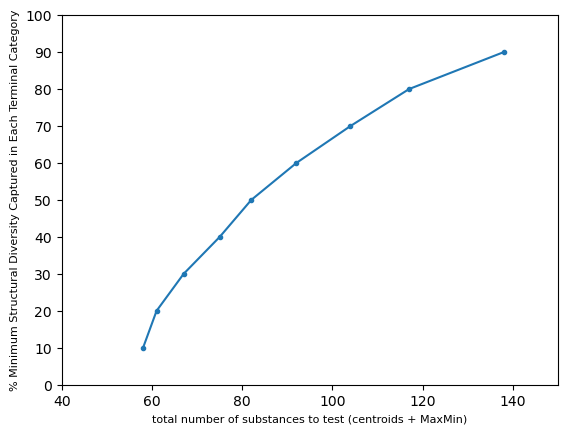

In [75]:
plt.figure(figsize = (10,9))
df5.plot(y = 'threshold', x= '#', marker = '.',legend = False)
plt.xlim(40,150)
plt.ylim(0,100)
plt.yticks(np.arange(0, 100+10, 10.0))
plt.ylabel('% Minimum Structural Diversity Captured in Each Terminal Category', fontsize = 8)
plt.xlabel('total number of substances to test (centroids + MaxMin)', fontsize = 8)
plt.savefig(figures_dir+'Terminal_categorisation_constrained_landscape_261123.png', dpi = 300)
